# Word2Vec: GENSIM-Package

In diesem Notebook wollen wir uns ein realistischeres Beispiel anschauen. Eine bekannte Bibliothek für Word2Vec Modelle ist das *gensim* Paket (https://radimrehurek.com/gensim/). Mit diesem Paket wollen wir ein Word2Vec Modell mit Hilfe eines deutlich größerem Datensatz trainieren und die Ergebnisse auswerten. 

In [3]:
import gensim
import os
import multiprocessing
from scipy.spatial.distance import cosine

## Datensatz: Deutsch

Beispieldatensätze kann man zum Beispiel unter folgendem Link bekommen:

> http://wortschatz.uni-leipzig.de/en/download/

alternativ auch direkt von gensim-data Storage:

> https://github.com/RaRe-Technologies/gensim-data

Schauen wir uns die ersten 10 Sätze des Datensatzes mal an:

In [9]:
with open("corpus/news2013.corpus", 'r') as outfile:
    for index, line in enumerate(outfile):
        print(line)
        if index > 10:
            break

Wenn oesterreichisch-britische Rennkombination Red Bull erfolgreich weitermacht greift Hesse womoeglich Titelrekord Schumacher

Auch Erkenntnissen amerikanischen Geheimdienste profitiert sollten darf Amerikaner erledigen Deutschen duerfen

Mit 22 Punkten fuehrt Deutschland Qualifikationsgruppe C Schweden 17 Oesterreich 14

Der neue Sicherungsanhaenger bietet laut Aussage Kommandanten fast Drittel Einsatzfaelle Schutz Verkehrsfluss Autobahn unfalltraechtigen Lappersdorfer Kreisel Kreisstrassen

Diese neue Form Erinnerungskultur entwickelte Demnig Ende 1990er-Jahre

Er sagte lange

Bereits vergangenen Jahr Kaercher rund 1,9 Milliarden Euro Umsatz Hoechstwert verbucht zudem viele Geraete nie verkauft

Da ganz vorne staedtischen Kliniken groesste Sorgen bereiten Der Sanierungsbedarf vier Haeuser sei erschreckend hoch Wirtschaftlichkeit erreicht

Steinharts Firma sei schon Grossbrand finanziell angeschlagen

Rhoen legte kuerzlich beim Oberlandesgericht Duesseldorf Beschwerde Entscheidung Bu

> **Achtung** der Inhalt des Files 'corpus/news2013.corpus' wurde schon vorverarbeitet, d.h. keine  Satzzeichen und einige Stop-Words sind schon entfernt worden.

**Zusammenfassung**:
 - 34.851.687 Sätze
 - Nachrichtenmeldungen von 2013
 - Sprache: deutsch

# Word2Vec Model

Mit Hilfe des Datensatzes  wollen wir eine Vektor-Embedding der deutschen Sprache entwickeln. Hierfür benutzen wir das gensim Python-Package und definieren uns einen Iterator (Generator), der über jeden Satz iteriert: 

In [10]:
# get corpus sentences
class CorpusSentences(object):
    def __init__(self, dirname):
        self.dirname = dirname

    def __iter__(self):
        for fname in os.listdir(self.dirname):
            with open(os.path.join(self.dirname, fname)) as fp:
                for line in fp:
                  yield line.split()

In [3]:
sentences  = CorpusSentences('corpus')

Nun können wir das Word2Vec Modell trainieren:

In [4]:
#model = gensim.models.Word2Vec(
#    sentences,
#    size=300,
#    window=10,
#    min_count=50,
#    negative=5,
#    workers=multiprocessing.cpu_count(),
#    sg=1
#)
#model.save("word2vec_hsoffenburg.model")

Alternativ kann man auch ein vortrainiertes Modell laden:

In [12]:
model = gensim.models.Word2Vec.load('word2vec_hsoffenburg.model')

> **Bemerkung**: das geladene Model wurde mit den gleichen Parametern wie oben trainiert. Die Trainingszeit auf einem Laptopn (4 CPUs) dauert ca 6h.

# Semantische Arithmetik

Einer der großen Vorteile von Vektorrepräsentationen von Word2Vec Modellen ist, dass semantische Beziehungen von Vektoren gleiche länge und richtung beschrieben werden können. Ein paar Beispiele sind zum Beispiel:

$$\vec{Mutter} = \vec{Frau} + \vec{Kind}$$

oder auch 

$$\vec{Berlin} = \vec{Deutschland} + \vec{Hauptstadt}$$

In [43]:
mutter = model.wv['Frau'] + model.wv['Kind']
# Similarity of Mutter = Frau + Kind
print('Similarity: {:0.2f}'.format(1-cosine(mutter, model.wv['Mutter'])))
print('Similarity: {:0.2f}'.format(1-cosine(model.wv['Frau'], model.wv['Mutter'])))

Similarity: 0.80
Similarity: 0.75


In [42]:
model.wv.most_similar(['Frau', 'Kind'])

[('Mutter', 0.8028054237365723),
 ('Ehemann', 0.7042809724807739),
 ('Ehefrau', 0.7041796445846558),
 ('Mann', 0.6987317800521851),
 ('Baby', 0.6844437122344971),
 ('Tochter', 0.6742666959762573),
 ('Vater', 0.6726093888282776),
 ('Sohn', 0.6652235984802246),
 ('Kindes', 0.6543958187103271),
 ('Kleinkind', 0.6472859382629395)]

In [7]:
germany = model.wv['Deutschland']
capital = model.wv['Hauptstadt']

In [8]:
german_capital = germany + capital
german_capital_direct = model.wv['Berlin']

In [9]:
print('Similarity: {:0.2f}'.format(1-cosine(german_capital, german_capital_direct)))

Similarity: 0.67


In [40]:
print(model.wv.most_similar(positive=['Deutschland', 'Hauptstadt'])[0])
print(model.wv.most_similar(positive=['Frankreich', 'Hauptstadt'])[0])

('Berlin', 0.6758421659469604)
('Paris', 0.7114046812057495)


In [28]:
king = model.wv['fuhr']
queen = model.wv['fahren']
woman = model.wv['heute']
man = model.wv['gestern']

king_test = queen - woman + man

In [29]:
print('Similarity: {:0.2f}'.format(1-cosine(king, king_test)))

Similarity: 0.51


# Visualiesierung des trainierten German-Word2Vec Model

In [45]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [46]:
def fit_and_visualize_components(labels, data, add_arrows=True):
    # do the principal component analysis
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(data)
    results = pd.DataFrame({'label': labels, 'c1': principalComponents[:,0], 'c2': principalComponents[:,1]})
    # do the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    for word, x1, x2 in zip(results['label'], results['c1'], results['c2']):
        ax.annotate(word, (x1+0.05,x2+0.05 ))

    # add dots
    plt.scatter(results['c1'], results['c2'], marker ='o', color='red')
    plt.xlabel('principal component: 1')
    plt.ylabel('principal component: 2')
    ax.grid(color='grey', alpha=0.2)
    # add arrows to the plot
    if not add_arrows:
        return
    for index  in range(0, int(len(results)/2)):
        ax.annotate(
            "",
            xy=(results['c1'][index], results['c2'][index]),
            xytext=(results['c1'][index+int(len(results)/2)], results['c2'][index+int(len(results)/2)]),
            arrowprops=dict(arrowstyle="->", color='blue'))


## Versteht unser Modell den Zusammenhang zwischen Ländern und ihrer Hauptstädte?
Jetzt wollen wir noch verstehen ob unser trainiertes Modell das Prinzip von Landesnamen und den dazugehörigen Hauptstädten gelernt hat. Hierzu visualisieren wir die Vektorrepräsentationen der Hauptstädte un der Länder. Da wir einen 300-dim Raum schlecht visualisieren können verwenden wir die Technik der "Principal-Component-Analysis" (PCA, Hauptkomponentenanalyse) um die Dimensionen auf zwei zu reduzieren.

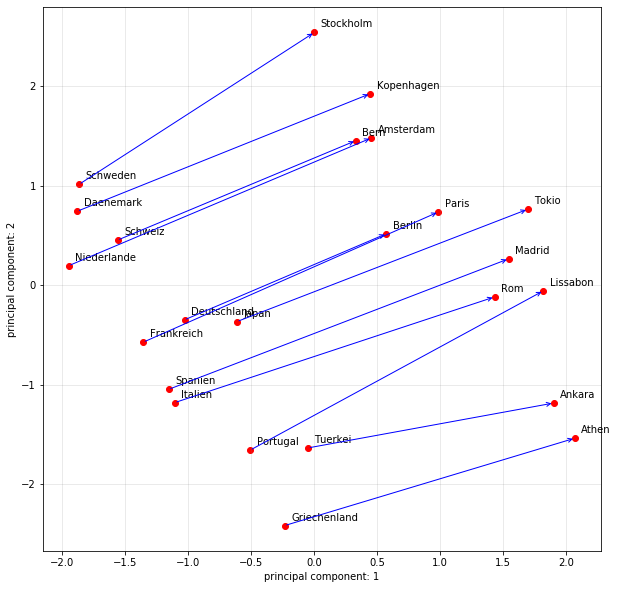

In [47]:
list_of_capitals = ['Berlin','Paris', 'Amsterdam', 'Madrid', 'Rom', 'Bern', 'Kopenhagen', 'Tokio', 'Ankara', 'Stockholm', 'Athen', 'Lissabon']
list_of_countrys = ['Deutschland', 'Frankreich', 'Niederlande', 'Spanien', 'Italien', 'Schweiz', 'Daenemark', 'Japan', 'Tuerkei', 'Schweden', 'Griechenland', 'Portugal']

#get vector representations
capitals = [model.wv[x] for x in list_of_capitals]
country = [model.wv[x] for x in list_of_countrys]

combined = capitals+country
labels = list_of_capitals + list_of_countrys
# do the pca and plot the results
fit_and_visualize_components(labels, combined)

# Spache vs. Land
Das gleiche Spiel nochmal für Sprachen und Landesnamen:

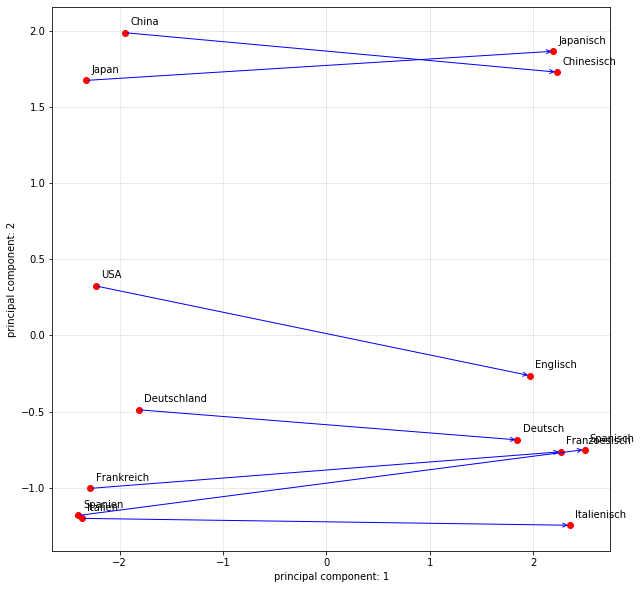

In [48]:
list_of_languages = ['Deutsch', 'Franzoesisch', 'Spanisch', 'Italienisch','Japanisch','Englisch', 'Chinesisch']
list_of_countrys = ['Deutschland', 'Frankreich','Spanien', 'Italien', 'Japan', 'USA', 'China']

#get vector representations
languages = [model.wv[x] for x in list_of_languages]
country = [model.wv[x] for x in list_of_countrys]

combined = languages+country
labels = list_of_languages + list_of_countrys
# do the pca and plot the results
fit_and_visualize_components(labels, combined)

# Vornamen der ProfessorenInnen der Fakultät EMI?

https://ei.hs-offenburg.de/ansprechpartner/professoreninnen/


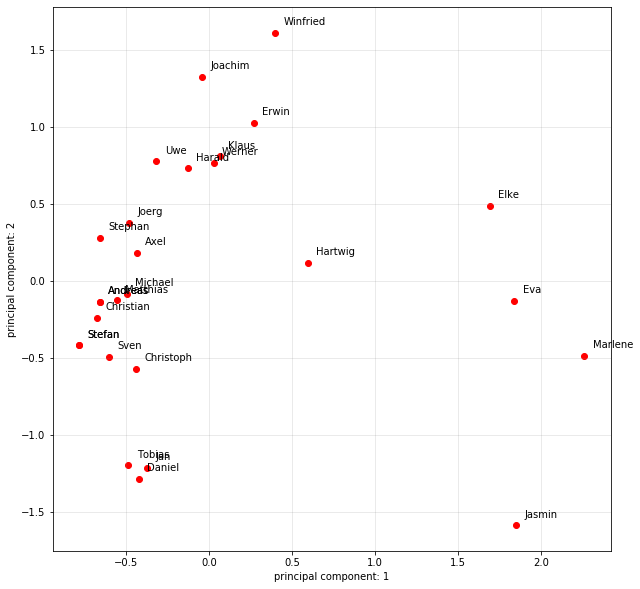

In [53]:
_names = ['Jasmin', 'Andreas', 'Eva', 'Klaus', 'Tobias', 'Joerg', 'Daniel',
         'Hartwig', 'Marlene', 'Matthias', 'Stefan', 'Harald', 'Christian',
         'Winfried', 'Elke', 'Erwin', 'Sven', 'Jan', 'Christoph', 'Uwe',
         'Joachim', 'Andreas', 'Werner', 'Michael', 'Axel', 'Stephan', 'Stefan']
names = [model.wv[x] for x in _names]
fit_and_visualize_components(_names, names, add_arrows=False)

Der Name Hartwig wird öfters im selben Kontext wie weibliche Vornamen erwähnt als andere männliche Vornamen. Warum ist dies der Fall?
Lösung: https://de.wikipedia.org/wiki/Hartwig